# Monte Carlo Dropout (MCD) Quantification

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

The aim of this file is it to analyse the MCD uncertainty and identify correlations to other metrics. Furhtermore, the computational efficiency of MCD simulations should be analyzed and the minimal number of needed MCD simulations for a robust uncertainty estimation quantified.

**Dependencies**: 
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans

from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters

import DataReader
importlib.reload(DataReader)
from DataReader import DataReader

import DNN
importlib.reload(DNN)
from DNN import DNN

import warnings
warnings.filterwarnings('ignore')

### Directory

In [2]:
directory = Directory()
plot_params = Plotting_Parameters()

model_name = "DNN_Model_Full_V2"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


### Load Data

In [3]:
datareader = DataReader()
df_full = datareader.load("Knee_Connection_Output_red.csv")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
Knee_Connection_Output_red.csv: (714385, 53)


## Load Model

In [4]:
model = DNN()
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

print(model.data['data_reduction_factor'])

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization
0


## Evaluate Model

In [5]:
y_pred, test_loss = model.evaluate()
y_true = model.y_test.numpy()
model.get_metrics(y_pred.numpy())

{'MSE': 3.0262208e-05,
 'RMSE': 0.0055011096,
 'MAE': 0.0037498153,
 'R2': 0.9979710623156279,
 'MCDMS': 0.004960395386702371,
 'MCDUS': 0.061298007002502264}

Get uncertainty of full data set. 

⚠️Attention⚠️: The returned and `mcd_std_unbiased` is unbiased (N-1). When calculating the standard deviation with `np.mean(data,axis=0)` the default is a biased (N) calulcation. Since the actual absolute values does not matter, but only the relative value, it does not matter which one is considered, but it should be consistant.

In [6]:
mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(num_samples=1000, dropout_prob=0.1)

$$\sigma_{\text{MC}}=\frac{\sigma}{\mu}$$

In [7]:
uncertainty = mcd_std_unbiased / mcd_mean

In [8]:
mcd_std = np.std(mcd_preds, axis=0)

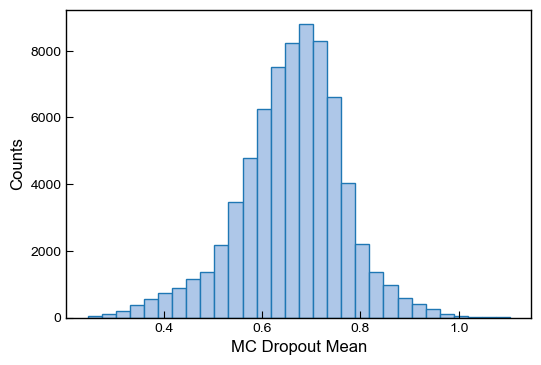

In [9]:
fig, ax = plt.subplots(figsize=(6,4))

_ = plt.hist(mcd_mean, 
             bins=30, 
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])
plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.show()

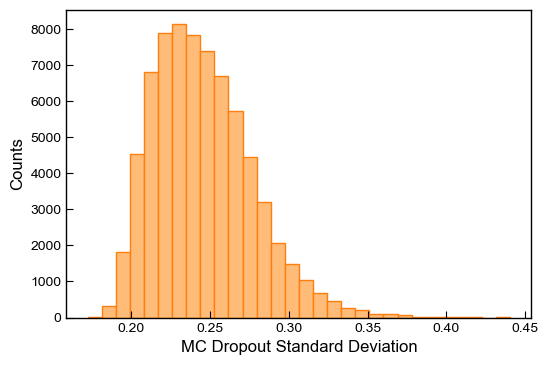

In [10]:
fig, ax = plt.subplots(figsize=(6,4))

_ = plt.hist(mcd_std_unbiased, 
             bins=30, 
             facecolor=plot_params.morecolors[3],
             edgecolor=plot_params.morecolors[2])
plt.xlabel('MC Dropout Standard Deviation')
plt.ylabel('Counts')

plt.show()

### Estimate Distribution Families

In [11]:
import scipy.stats as stats

def fit_and_select_distribution(data, distributions):
    results = []
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            log_likelihood = np.sum(dist.logpdf(data, *params))
            k = len(params)
            aic = 2 * k - 2 * log_likelihood
            results.append((dist_name, aic))
        except Exception:
            continue
    
    results.sort(key=lambda x: x[1])
    return results


In [12]:
candidate_distributions = [
    'gamma', 'skewnorm', 'lognorm', 'weibull_min', 'beta',
    'gumbel_r', 'pareto', 'nakagami', 'expon', 'johnsonsu', 
    'triang', 'genextreme'
]

mcd_mean_best_fits = fit_and_select_distribution(mcd_mean, candidate_distributions)
mcd_std_best_fits = fit_and_select_distribution(mcd_std_unbiased, candidate_distributions)
uncertainty_best_fits = fit_and_select_distribution(uncertainty, candidate_distributions)

print("Best fit distributions for MCD Mean:")
for dist_name, aic in mcd_mean_best_fits:
    print(f"{dist_name}: AIC = {aic}")

print("\nBest fit distributions for MCD Std:")
for dist_name, aic in mcd_std_best_fits:
    print(f"{dist_name}: AIC = {aic}")

print("\nBest fit distributions for Uncertainty:")
for dist_name, aic in uncertainty_best_fits:
    print(f"{dist_name}: AIC = {aic}")

Best fit distributions for MCD Mean:
johnsonsu: AIC = -119987.0097452945
skewnorm: AIC = -118546.67291638693
beta: AIC = -118013.95490576992
weibull_min: AIC = -117391.7524314253
lognorm: AIC = -116618.50316407236
nakagami: AIC = -116600.26078425895
gamma: AIC = -115050.19154688012
genextreme: AIC = -112588.50908331232
gumbel_r: AIC = -94360.08221844141
triang: AIC = -86228.23499395404
expon: AIC = 16990.153810850774
pareto: AIC = 17011.942030615508

Best fit distributions for MCD Std:
beta: AIC = -300826.73556560266
gamma: AIC = -300815.934154097
skewnorm: AIC = -300574.40849511727
lognorm: AIC = -300500.8730241789
johnsonsu: AIC = -300482.39391600876
genextreme: AIC = -300318.540025121
gumbel_r: AIC = -300058.6628528706
nakagami: AIC = -299500.7015974802
weibull_min: AIC = -297749.7808660259
triang: AIC = -256662.59409246116
expon: AIC = -230598.74707108556
pareto: AIC = -230578.055459605

Best fit distributions for Uncertainty:
johnsonsu: AIC = -289857.7567368516
genextreme: AIC = -

In [13]:
from scipy.stats import gamma, johnsonsu

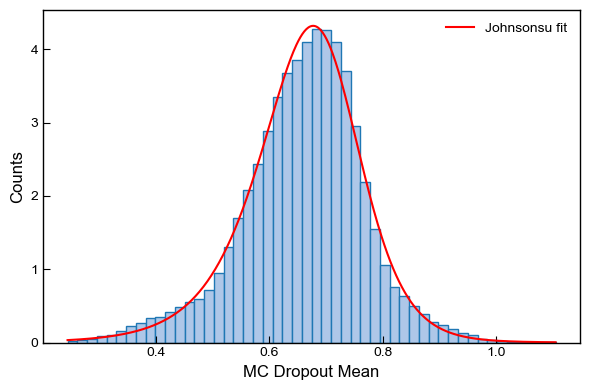

In [22]:
fig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(mcd_mean), max(mcd_mean), 500)

mcd_mean_params = johnsonsu.fit(mcd_mean)
mcd_mean_pdf = johnsonsu.pdf(x, *mcd_mean_params)

_ = plt.hist(mcd_mean, 
             bins=50, 
             density=True,
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])

plt.plot(x, mcd_mean_pdf, 'r-', label='Johnsonsu fit')

plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.legend()
plt.tight_layout()
plt.show()

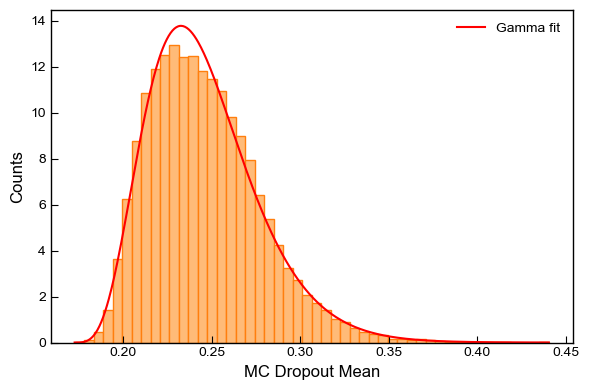

In [21]:
ffig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(mcd_std_unbiased), max(mcd_std_unbiased), 500)

mcd_std_params = gamma.fit(mcd_std_unbiased)
mcd_std_pdf = gamma.pdf(x, *mcd_std_params)

_ = plt.hist(mcd_std_unbiased, 
             bins=50, 
             density=True,
             facecolor=plot_params.morecolors[3],
             edgecolor=plot_params.morecolors[2])

plt.plot(x, mcd_std_pdf, 'r-', label='Gamma fit')

plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.legend()
plt.tight_layout()
plt.show()

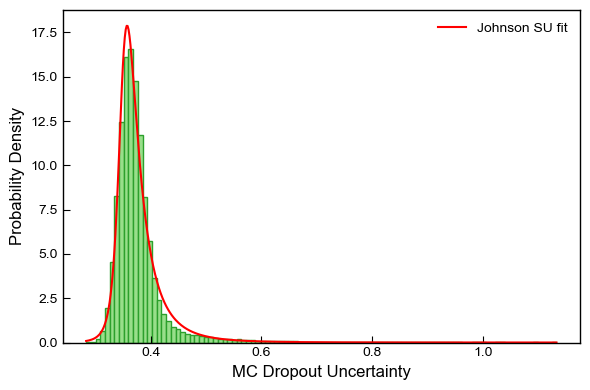

In [20]:
ffig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(uncertainty), max(uncertainty), 500)

mcd_uncertainty_params = johnsonsu.fit(uncertainty)
mcd_uncertainty_pdf = johnsonsu.pdf(x, *mcd_uncertainty_params)

_ = plt.hist(uncertainty, 
             bins=100, 
             density=True,
             facecolor=plot_params.morecolors[5],
             edgecolor=plot_params.morecolors[4])

plt.plot(x, mcd_uncertainty_pdf, 'r-', label='Johnson SU fit')

plt.xlabel('MC Dropout Uncertainty')
plt.ylabel('Probability Density')

plt.legend()
plt.tight_layout()
plt.show()


$$
f(x) = \frac{\delta}{\sqrt{2\pi} \sqrt{(x - \xi)^2 + \lambda^2}} \exp\left( -\frac{1}{2} \left[ \gamma + \delta \cdot \sinh^{-1}\left( \frac{x - \xi}{\lambda} \right) \right]^2 \right)
$$


𝛾
γ: shape

𝛿
δ: shape

𝜉
ξ: location

𝜆
λ: scale

Finance: Modeling asset returns or income distributions where skew and kurtosis matter.

Hydrology & Meteorology: Rainfall, flood magnitudes, or wind speeds with skewed behavior.

Biostatistics: Physiological measurements that aren't normally distributed.

Reliability Engineering: Modeling life data with non-symmetric failure distributions.

Machine Learning & Simulation: As a flexible parametric input when standard distributions (normal, gamma, etc.) underperform.

Use central limit theorem:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>n</mi><mo>≥</mo><msup><mrow><mo fence="true">(</mo><mfrac><mrow><msub><mi>z</mi><mrow><mn>1</mn><mo>−</mo><mi>α</mi><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msub><mo>⋅</mo><mi>σ</mi></mrow><mrow><mi>p</mi><mo>⋅</mo><mi>μ</mi></mrow></mfrac><mo fence="true">)</mo></mrow><mn>2</mn></msup></mrow><annotation encoding="application/x-tex">n \ge \left( \frac{z_{1 - \alpha/2} \cdot \sigma}{p \cdot \mu} \right)^2</annotation></semantics></math>

In [17]:
mcd_uncertainty_params

(-0.9004417710721797,
 1.0787503913053944,
 0.3479570222829158,
 0.020007834770595707)

In [19]:
from scipy.stats import norm

In [24]:
a, b, loc, scale = mcd_uncertainty_params

mu, var = johnsonsu.stats(a, b, loc=loc, scale=scale, moments='mv')
sigma = var**0.5

# Target relative error p and confidence level (e.g., 95%)
p = 0.05
z = 1.96

z = norm.ppf(0.95)

n_required = (z * sigma / (p * mu))**2
print(f"Required sample size: {int(np.ceil(n_required))}")

Required sample size: 16


### Effect of MC Simulation Number

In [25]:
df_reduced = df_full.sample(10000).copy()

In [28]:
simulations_tests = [5,10,15,20,50,100,200,500,750,1000]

In [29]:
uncertainty_progression = np.zeros((len(df_reduced), len(simulations_tests)))

for n_simulations in simulations_tests:
    print(n_simulations)
    mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(
        df_input = df_reduced,
        num_samples=n_simulations, 
        dropout_prob=0.1)
    uncertainty = mcd_std_unbiased / mcd_mean

    uncertainty_progression[:, simulations_tests.index(n_simulations)] = uncertainty.flatten()

5
10
15
20
50
100
200
500
750
1000


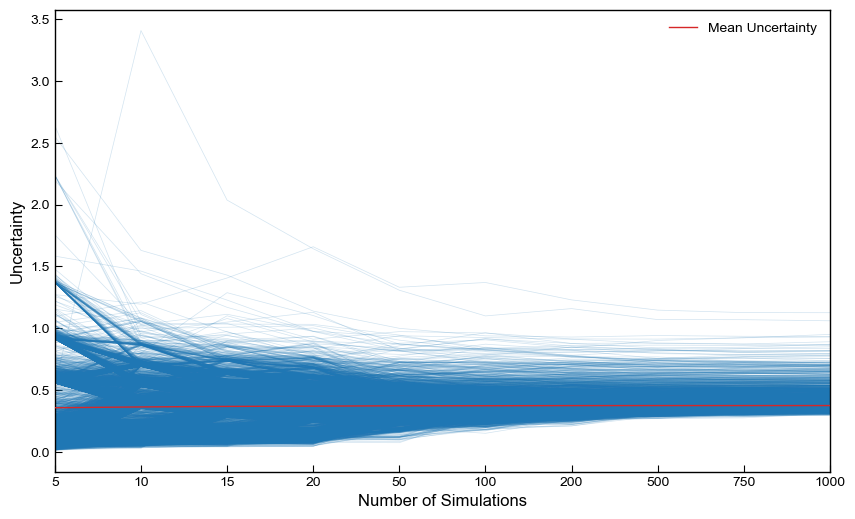

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_reduced)):
    plt.plot(uncertainty_progression[i],
             linewidth=0.5,
             alpha=0.2,
             c=plot_params.colors[0]
    )

plt.plot(np.mean(uncertainty_progression, axis=0),
         linewidth=1,
         c=plot_params.colors[3],
         label="Mean Uncertainty",
         zorder=10
    )

plt.legend()

plt.xlabel("Number of Simulations")
plt.ylabel("Uncertainty")

plt.xticks(range(len(simulations_tests)), simulations_tests)

plt.xlim([0, len(simulations_tests)-1])

plt.show()

In [31]:
final_uncertainty = uncertainty_progression[:, -1].reshape(-1, 1)
deviation_from_final = uncertainty_progression / final_uncertainty

In [32]:
accepted_deviation = 0.05

In [33]:
ratio_of_accepted = np.array([np.count_nonzero(np.abs(deviation_from_final[:,i]-1)<=accepted_deviation)/len(df_reduced) for i in range(len(simulations_tests))])

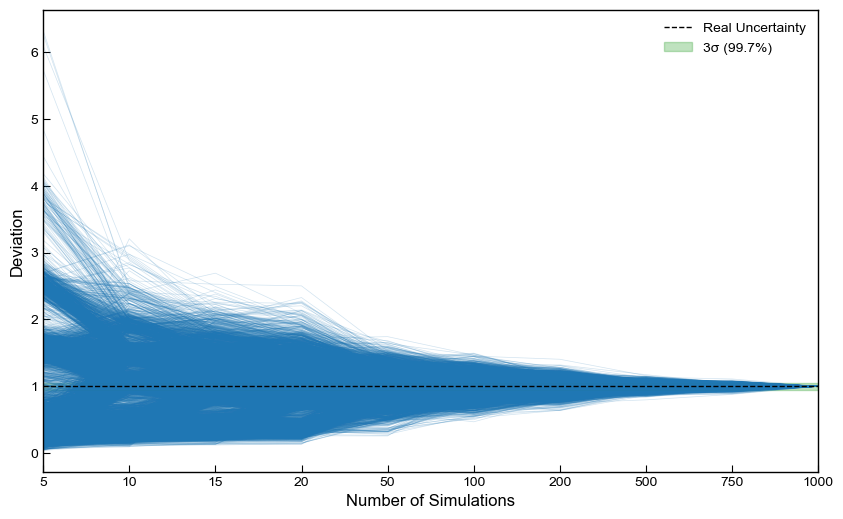

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_reduced)):
    plt.plot(deviation_from_final[i],
             linewidth=0.5,
             alpha=0.2,
             c=plot_params.colors[0]
    )

plt.axhline(y=1, color='k', linestyle='--', linewidth=1, label="Real Uncertainty")

plt.axhspan(1-accepted_deviation, 1+accepted_deviation, 
            alpha=0.3, 
            color=plot_params.colors[2], 
            label='3σ (99.7%)', zorder=0)

plt.legend()

plt.xlabel("Number of Simulations")
plt.ylabel("Deviation")

plt.xticks(range(len(simulations_tests)), simulations_tests)

plt.xlim([0, len(simulations_tests)-1])

plt.show()

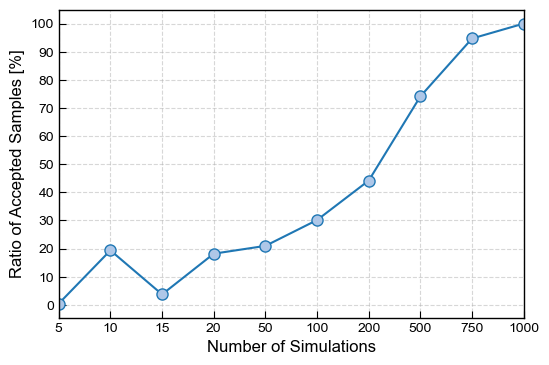

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ratio_of_accepted, 
         marker='o', 
         markersize=8,
         markerfacecolor=plot_params.morecolors[1],
         markeredgecolor=plot_params.morecolors[0], 
         label='Accepted Ratio')

plt.xlabel('Number of Simulations')
plt.ylabel('Ratio of Accepted Samples [%]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, len(simulations_tests)-1)
plt.xticks(range(len(simulations_tests)), simulations_tests)
plt.yticks(np.arange(0, 1.1, 0.1),np.arange(0,101,10))

plt.show()

In [36]:
from scipy.stats import rankdata, spearmanr

def rank_stability_analysis(arr):
    n_cols = arr.shape[1]
    rank_changes = []
    
    for i in range(n_cols - 1):
        rank1 = rankdata(arr[:, i], method='ordinal')
        rank2 = rankdata(arr[:, i + 1], method='ordinal')
        corr, _ = spearmanr(rank1, rank2)
        rank_changes.append(1 - corr)
    
    return np.array(rank_changes)

In [37]:
rank_stability_analysis(uncertainty_progression)

array([0.29929152, 0.18450251, 0.13368522, 0.35141906, 0.25737788,
       0.23820871, 0.26477435, 0.10907295, 0.07125778])

In [38]:

def total_rank_changes(arr):
    n_rows, n_cols = arr.shape
    total_changes = []

    for i in range(n_cols - 1):
        rank1 = rankdata(arr[:, i], method='ordinal')
        rank2 = rankdata(arr[:, i + 1], method='ordinal')
        change = np.abs(rank1 - rank2)
        total_changes.append(np.sum(change))
    
    return np.array(total_changes)

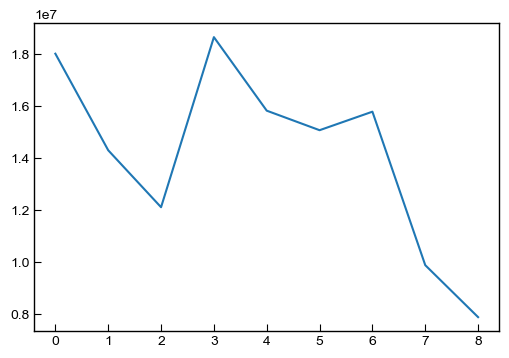

In [39]:
plt.plot(total_rank_changes(uncertainty_progression))

In [40]:
diff_normalized = np.diff(uncertainty_progression) / final_uncertainty

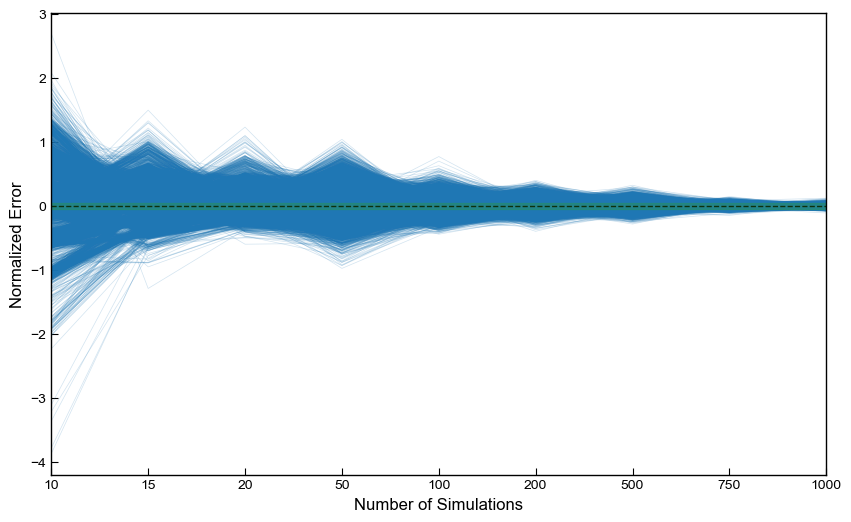

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(diff_normalized.T,
         linewidth=0.5,
         alpha=0.2,
         c=plot_params.colors[0]
    )

plt.axhline(y=0, color='k', linestyle='--', linewidth=1)

plt.axhspan(-accepted_deviation, accepted_deviation, 
            alpha=0.3, 
            color=plot_params.colors[2], 
            label=f'Accepted Error range ({accepted_deviation*100:0f})', 
            zorder=2)

plt.xlabel('Number of Simulations')
plt.ylabel('Normalized Error')

plt.xticks(range(len(simulations_tests)-1), simulations_tests[1:])
plt.xlim([0, len(simulations_tests)-2])

plt.show()

In [49]:
mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(
    df_input = df_reduced,
    num_samples=int(n_required), 
    dropout_prob=0.1)
uncertainty = mcd_std_unbiased / mcd_mean

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


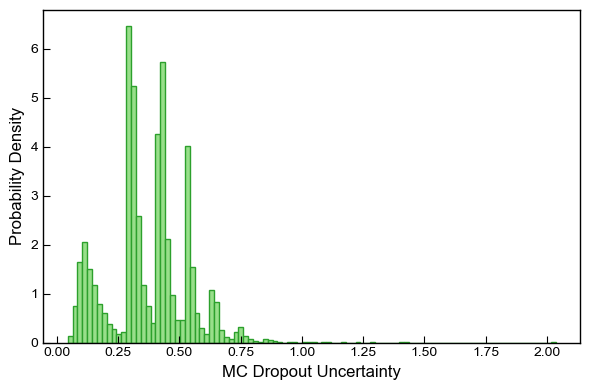

In [50]:
fig, ax = plt.subplots(figsize=(6,4))

#x = np.linspace(min(uncertainty), max(uncertainty), 500)

#mcd_uncertainty_params = johnsonsu.fit(uncertainty)
#mcd_uncertainty_pdf = johnsonsu.pdf(x, *mcd_uncertainty_params)

_ = plt.hist(uncertainty, 
             bins=100, 
             density=True,
             facecolor=plot_params.morecolors[5],
             edgecolor=plot_params.morecolors[4])

#plt.plot(x, mcd_uncertainty_pdf, 'r-', label='Johnson SU fit')

plt.xlabel('MC Dropout Uncertainty')
plt.ylabel('Probability Density')

plt.legend()
plt.tight_layout()
plt.show()

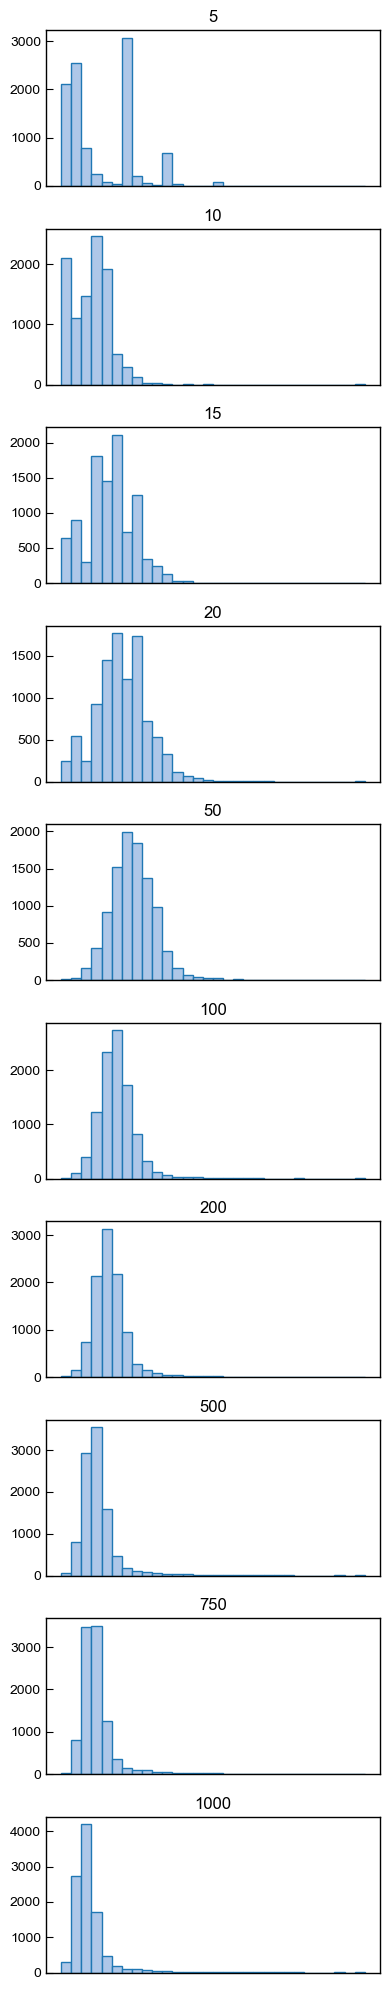

In [62]:
fig, axs = plt.subplots(uncertainty_progression.shape[1],1,figsize=(4,2*uncertainty_progression.shape[1]))

for i in range(uncertainty_progression.shape[1]):
    axs[i].hist(uncertainty_progression[:,i], 
             bins=30, 
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])
    axs[i].set_xticks([])
    axs[i].set_title(simulations_tests[i])
    
plt.tight_layout()
plt.show()